In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import date
import datetime
from statsmodels.tsa.arima_model import ARIMA

In [3]:
df= pd.read_csv('F:/studies/project/New folder/covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [4]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
#df['Last Update'] = pd.to_datetime(df['Last Update'])
df['Confirmed']=df['Confirmed'].astype('int')
df['Deaths']=df['Deaths'].astype('int')
df['Recovered']=df['Recovered'].astype('int')

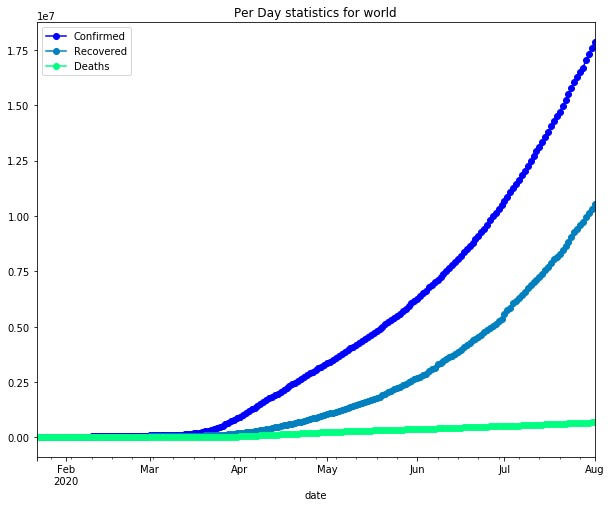

In [5]:
world_cases=df
world_cases['date'] = world_cases['ObservationDate'].dt.date
world_cases['date']=pd.to_datetime(world_cases['date'])
world_cases = world_cases[world_cases['date'] > pd.Timestamp(date(2020,1,21))]
num_plot= world_cases.groupby('date')["Confirmed", "Recovered", "Deaths"].sum()
num_plot.plot(figsize=(10,8),colormap='winter',title='Per Day statistics for world',marker='o')
num_plot_world=num_plot.reset_index()

[Text(0, 0.5, 'Confirmed Cases'), Text(0.5, 0, 'Date')]

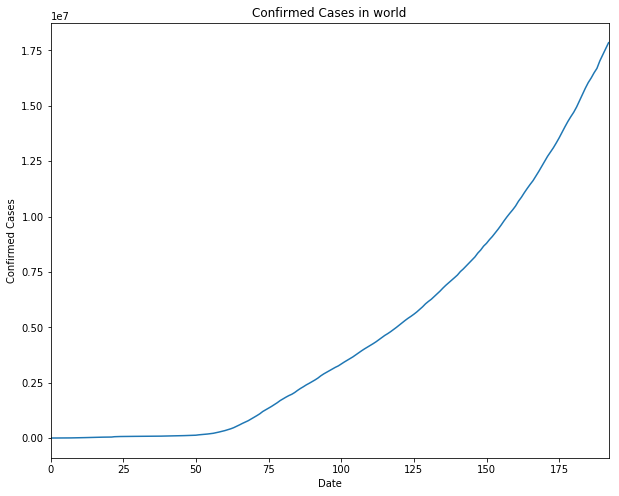

In [6]:
#Current number of confirmed cases
ax = num_plot_world['Confirmed'].plot(title="Confirmed Cases in world",figsize=(10,8));
ax.set(xlabel="Date", ylabel="Confirmed Cases")

# Preduction for India

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


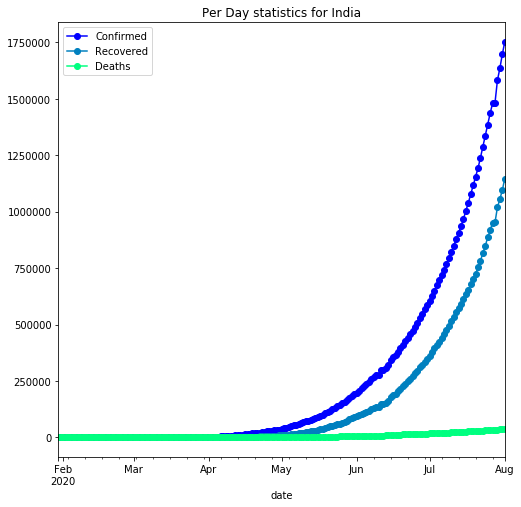

In [7]:
india_cases_complete=df.loc[df['Country/Region']=='India']
india_cases_complete['date'] = india_cases_complete['ObservationDate'].dt.date
india_cases_complete['date']=pd.to_datetime(india_cases_complete['date'])
india_cases_complete = india_cases_complete[india_cases_complete['date'] > pd.Timestamp(date(2020,1,21))]
num_plot1= india_cases_complete.groupby('date')["Confirmed", "Recovered", "Deaths"].sum()
num_plot1.plot(figsize=(8,8),colormap='winter',title='Per Day statistics for India',marker='o')
num_plot_india=num_plot1.reset_index()

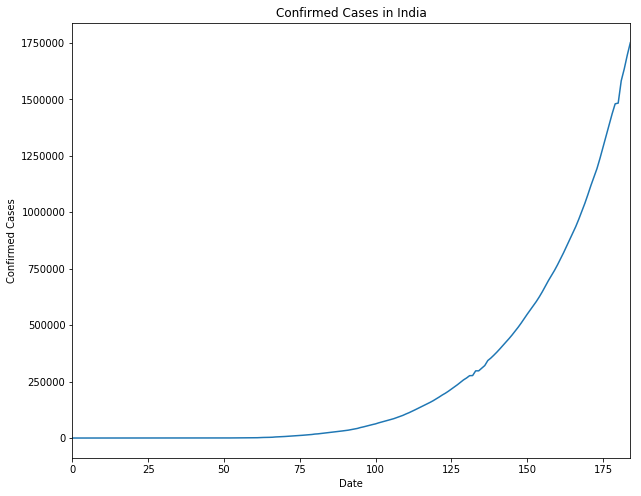

In [8]:
#Current number of confirmed cases
ax = num_plot_india['Confirmed'].plot(title="Confirmed Cases in India",figsize=(10,8));
ax.set(xlabel="Date", ylabel="Confirmed Cases");

In [9]:
a=num_plot_world[['date','Confirmed']]

In [10]:
a.set_index('date',inplace=True)

In [11]:
a.head()

,Confirmed
date,
2020-01-22,555
2020-01-23,653
2020-01-24,941
2020-01-25,1438
2020-01-26,2118


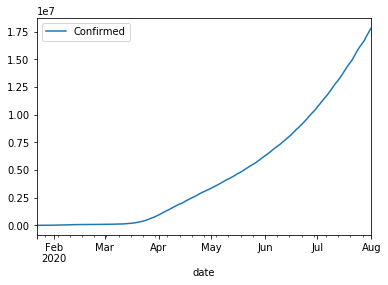

In [12]:
a.plot()

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
test_result=adfuller(a['Confirmed'])

In [15]:
def adfuller_test(confirmed):
    result=adfuller(confirmed)
    lables=['ADF Test Statstic','p-value','#lags used','no of observations used']
    for value,lable in zip(result,lables):
        print(lable+':'+str(value))
    if result[1]<=0.05:
        print('data is stationary')
    else:
        print('data is non stationary')

In [16]:
adfuller_test(a['Confirmed'])

ADF Test Statstic:1.3816473043682713
p-value:0.9970291527041599
#lags used:12
no of observations used:180
data is non stationary


In [17]:
a['first diff']=a['Confirmed']-a['Confirmed'].shift(57)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
#a.head()

In [19]:
adfuller_test(a['first diff'].dropna())

ADF Test Statstic:1.323050163500631
p-value:0.9967349278872828
#lags used:12
no of observations used:123
data is non stationary


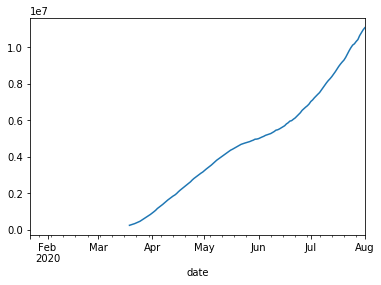

In [20]:
a['first diff'].plot()

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

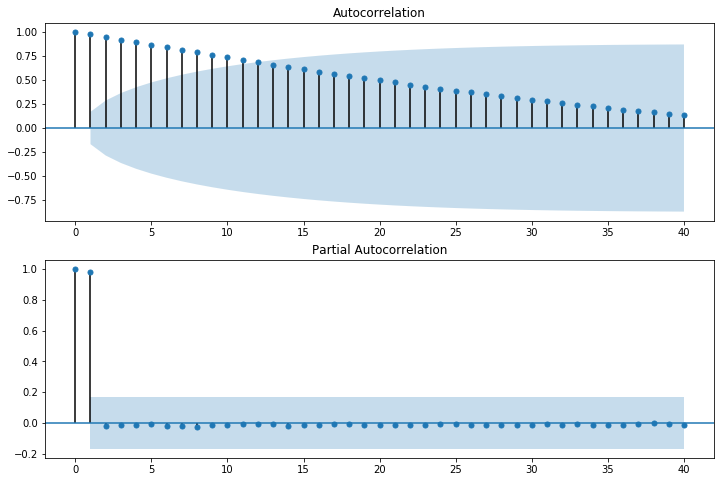

In [22]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(a['first diff'].iloc[57:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(a['first diff'].iloc[57:],lags=40,ax=ax2)

# Arima Model prediction (Worldwide)

In [23]:
train1= num_plot_world.iloc[:-5,:2]
test1= num_plot_world.iloc[-5:,:2]

In [24]:
train1.rename(columns={"date":"ds1","Confirmed":"y1"},inplace=True)
test1.rename(columns={"date":"ds1","Confirmed":"y1"},inplace=True)
test1= test1.set_index("ds1")
test1= test1['y1']

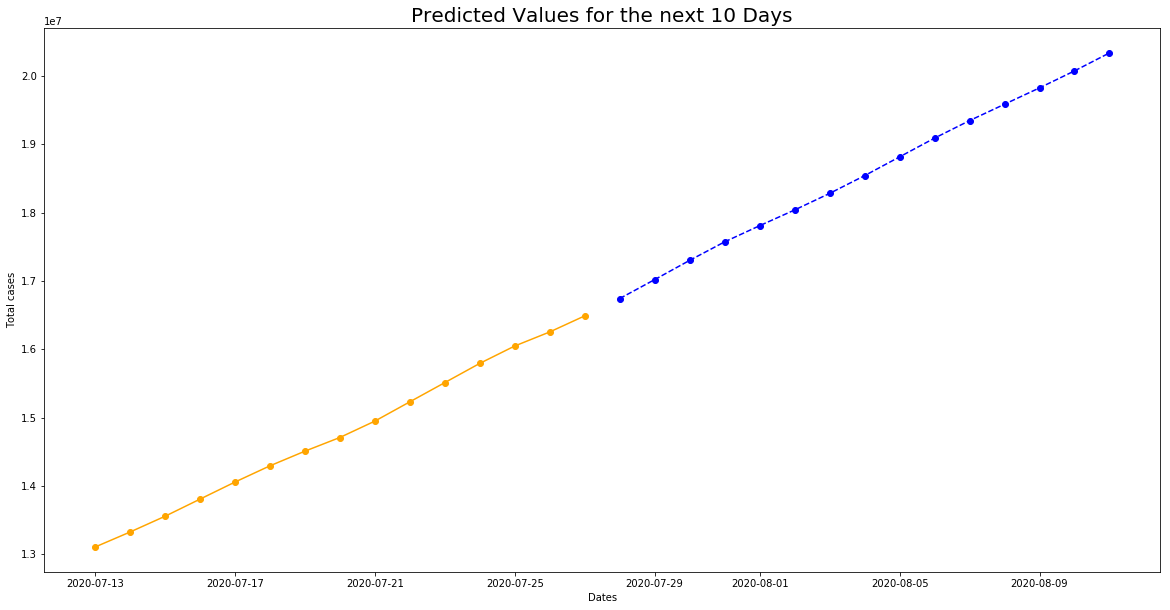

In [25]:
arima = ARIMA(train1['y1'], order=(7, 2, 0))
arima = arima.fit(trend='nc', full_output=True, disp=True)
forecast = arima.forecast(steps= 15)
pred = list(forecast[0])
start_date = train1['ds1'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (20,10))
plt.xlabel("Dates",fontsize = 10)
plt.ylabel('Total cases',fontsize = 10)
plt.title("Predicted Values for the next 10 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = 'blue',label = 'Predicted')
plt.plot_date(y=train1['y1'].tail(15),x=train1['ds1'].tail(15),linestyle = '-',color = 'orange',label = 'Actual')

In [26]:
pred=pd.DataFrame(forecast[0],columns=['Predicted'])
dates=pd.DataFrame(prediction_dates,columns=['Date'])
arima_df=pd.merge(dates,pred,right_index=True,left_index=True)

In [27]:
arima_df['Predicted']=arima_df['Predicted'].astype(int)

In [28]:
arima_df.tail(10)

,Date,Predicted
5,2020-08-02,18037466
6,2020-08-03,18279693
7,2020-08-04,18539334
8,2020-08-05,18814280
9,2020-08-06,19088759
10,2020-08-07,19344970
11,2020-08-08,19584790
12,2020-08-09,19823879
13,2020-08-10,20072364
14,2020-08-11,20335709


In [29]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D2.y1   No. Observations:                  186
Model:                 ARIMA(7, 2, 0)   Log Likelihood               -2002.213
Method:                       css-mle   S.D. of innovations          11375.562
Date:                Thu, 18 May 2023   AIC                           4020.426
Time:                        16:42:48   BIC                           4046.231
Sample:                             2   HQIC                          4030.883
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1.D2.y1    -0.4513      0.071     -6.348      0.000      -0.591      -0.312
ar.L2.D2.y1    -0.1124      0.079     -1.431      0.154      -0.266       0.042
ar.L3.D2.y1    -0.3025      0.075     -4.012      0.000      -0.450      -0.155
ar.L4.D2.y1    -0.3628      0.076     -4.778      0.000      -0.512      -0.214
ar.L5.D2.y1    -0.3096      0.079     -3.943      0.000      -0.463      -0.156
ar.L6.D2.y1     0.1823      0.083      2.190      0.030       0.019       0.346
ar.L7.D2.y1     0.2583      0.076      3.396      0.001       0.109       0.407
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6195           -0.8483j            1.0504           -0.1496
AR.2            0.6195           +0.8483j            1.0504            0.1496
AR.3            1.5430           -0.0000j            1.5430           -0.0000
AR.4           -0.4902           -1.0597j            1.1675           -0.3190
AR.5           -0.4902           +1.0597j            1.1675            0.3190
AR.6           -1.2538           -0.3102j            1.2916           -0.4614
AR.7           -1.2538           +0.3102j            1.2916            0.4614
-----------------------------------------------------------------------------
"""

# Arima Model prediction (India)

In [30]:
train = num_plot_india.iloc[:-5,:2]
test = num_plot_india.iloc[-5:,:2]

In [31]:
train.rename(columns={"date":"ds","Confirmed":"y"},inplace=True)
test.rename(columns={"date":"ds","Confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

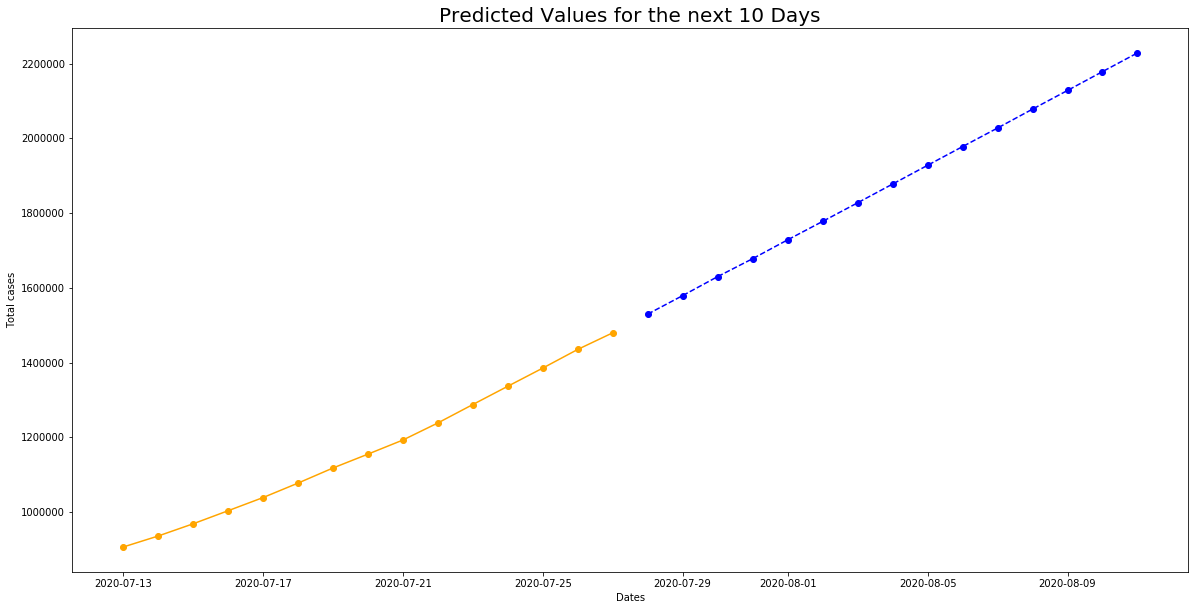

In [32]:
arima = ARIMA(train['y'], order=(7, 2, 0))
arimaind = arima.fit(trend='nc', full_output=True, disp=True)
forecast = arimaind.forecast(steps= 15)
pred = list(forecast[0])
start_date = train['ds'].max()
prediction_dates = []
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (20,10))
plt.xlabel("Dates",fontsize = 10)
plt.ylabel('Total cases',fontsize = 10)
plt.title("Predicted Values for the next 10 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = 'blue',label = 'Predicted')
plt.plot_date(y=train['y'].tail(15),x=train['ds'].tail(15),linestyle = '-',color = 'orange',label = 'Actual')

In [33]:
pred1=pd.DataFrame(forecast[0],columns=['Predicted for india'])
dates1=pd.DataFrame(prediction_dates,columns=['Date'])
arima_df1=pd.merge(dates1,pred1,right_index=True,left_index=True)


In [34]:
arima_df1['Predicted for india']=arima_df1['Predicted for india'].astype(int)

In [35]:
arima_df1.tail(10)

,Date,Predicted for india
5,2020-08-02,1778123
6,2020-08-03,1827868
7,2020-08-04,1878052
8,2020-08-05,1928216
9,2020-08-06,1978262
10,2020-08-07,2027957
11,2020-08-08,2078531
12,2020-08-09,2128475
13,2020-08-10,2178875
14,2020-08-11,2228963


In [36]:
arimaind.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  178
Model:                 ARIMA(7, 2, 0)   Log Likelihood               -1616.065
Method:                       css-mle   S.D. of innovations           2114.123
Date:                Thu, 18 May 2023   AIC                           3248.129
Time:                        16:42:52   BIC                           3273.584
Sample:                             2   HQIC                          3258.452
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D2.y    -0.6709      0.075     -8.940      0.000      -0.818      -0.524
ar.L2.D2.y    -0.1695      0.091     -1.869      0.063      -0.347       0.008
ar.L3.D2.y    -0.1224      0.089     -1.382      0.169      -0.296       0.051
ar.L4.D2.y     0.2652      0.086      3.099      0.002       0.097       0.433
ar.L5.D2.y     0.1786      0.094      1.892      0.060      -0.006       0.364
ar.L6.D2.y     0.1716      0.104      1.654      0.100      -0.032       0.375
ar.L7.D2.y     0.2554      0.082      3.119      0.002       0.095       0.416
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1832           -0.0000j            1.1832           -0.0000
AR.2           -1.1156           -0.2953j            1.1540           -0.4588
AR.3           -1.1156           +0.2953j            1.1540            0.4588
AR.4           -0.3513           -1.1597j            1.2118           -0.2968
AR.5           -0.3513           +1.1597j            1.2118            0.2968
AR.6            0.5396           -1.1835j            1.3007           -0.1819
AR.7            0.5396           +1.1835j            1.3007            0.1819
-----------------------------------------------------------------------------
"""

In [37]:
test=test.reset_index()

In [38]:
df1=pd.DataFrame(forecast[0],columns=['yhat'])
df2=pd.DataFrame(prediction_dates,columns=['ds'])
df3=test['y']
df4=pd.merge(df2,df3,right_index=True,left_index=True)
df5=pd.merge(df4,df1,right_index=True,left_index=True)

In [39]:
df5['mse'],df5['rmse'],df5['mae'],df5['mape'],df5['mdape']=[0,0,0,0,0]

In [40]:
for t in range(len(test)):
    mape =  np.mean(np.abs(df5['yhat'][t] - df5['y'][t])/np.abs(df5['y'][t]))
    df5['mape'][t]="{:.5f}".format(mape)
    mdape =  np.median(np.abs(df5['yhat'][t] - df5['y'][t])/np.abs(df5['y'][t]))
    df5['mdape'][t]="{:.5f}".format(mdape)
    mae = np.mean(np.abs(df5['yhat'][t] - df5['y'][t]))
    df5['mae'][t]=mae
    mse = np.mean((df5['yhat'][t] - df5['y'][t])**2)
    df5['mse'][t]=mse
    rmse = np.mean((df5['yhat'][t] - df5['y'][t])**2)**.5
    df5['rmse'][t]=rmse

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\An

In [41]:
df5

,ds,y,yhat,mse,rmse,mae,mape,mdape
0,2020-07-28,1483156,1.530102e+06,2203928890,46946,46946,0.03165,0.03165
1,2020-07-29,1581963,1.579664e+06,5283179,2298,2298,0.00145,0.00145
2,2020-07-30,1634746,1.630430e+06,18625574,4315,4315,0.00264,0.00264
3,2020-07-31,1695988,1.678412e+06,308907841,17575,17575,0.01036,0.01036
4,2020-08-01,1750723,1.728763e+06,482232245,21959,21959,0.01254,0.01254


In [42]:
dates=arima_df.tail(10)['Date']
aw=arima_df.tail(10)['Predicted']
ai=arima_df1.tail(10)['Predicted for india']

# Prediction results

In [43]:
model_predictions=pd.DataFrame(zip(dates,aw,ai),columns=['date','Arima prediction for world','Arima prediction for India'])
model_predictions

,date,Arima prediction for world,Arima prediction for India
0,2020-08-02,18037466,1778123
1,2020-08-03,18279693,1827868
2,2020-08-04,18539334,1878052
3,2020-08-05,18814280,1928216
4,2020-08-06,19088759,1978262
5,2020-08-07,19344970,2027957
6,2020-08-08,19584790,2078531
7,2020-08-09,19823879,2128475
8,2020-08-10,20072364,2178875
9,2020-08-11,20335709,2228963
